# Collection of frequency and peak velocity parameters from all pipelines
We already have velocity parameters that closely match the number of peaks of the Rosen EMAT with:
* Rosen MFL-C
* BHGE-MFL

The purpose of this workbook is to find velocity parameters to:
* Match the BH(I) Gemini with Rosen MFL-C
* Match the Rosen AFD with the BH(I) Gemini

In this sense, the the BH(I) Gemini and Rosen MFL-C are the "Rosetta Stones":
* Rosen AFD can predict BH(I) Gemini
* BH(I) Gemini can predict Rosen MFL-C
* Rosen MFL-C can predict EMAT

Thus: our hypothesis is that we can use velocity data from the Rosen AFD to, though a series of correlations, predict the number of speed excursions for the Rosen EMAT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import localdec

In [2]:
data_dir = "../SpeedData"
dist_col = 3
pls = pd.read_excel(data_dir + "/" +  "Datasets.xlsx",
                        sheet_name = "Datasets")
pls["Pipeline"] = pls["Filename"].str.extract("^(.*)\sVelocity.*")
pls.set_index("Pipeline", inplace=True)
pls.head(3)

,PiplineNo,Filename,Sheet,Header,Skip,SpeedData1,SpeedData2,SpeedData3,Tool1,Tool2,Tool3,PredictorTool
Pipeline,,,,,,,,,,,,
CH-NC_508,1,CH-NC_508 Velocity Excursion Review.xlsm,Sheet1,4,5,7,8.0,NaN,Velocity \n(2019 BHGE GEMINI MFL),Velocity \n(2013 ROSEN AFD ),NaN,ROSEN AFD
LIV_PAT_457,2,LIV_PAT_457 Velocity Excursion Review.xlsm,Event Log & Velocity Listing,4,5,6,7.0,8.0,Velocity (2019 BHGE MFL),Velocity (2019 ROSEN MFL-C),Velocity (2019 ROSEN EMAT (wSC)),ROSEN EMAT (wSC)
HUN_NIC_762,3,HUN_NIC_762 Velocity Excursion Review.xlsm,Sheet1,4,5,7,8.0,NaN,Velocity \n(2016 BH Gemini HD MFL (wSC)),Velocity \n(2017 ROSEN AFD ),NaN,ROSEN AFD


### Create tool dictionary from pipeline spreadsheet

In [3]:
pipelines = dict()
colheads = [x.group(1) for x in [re.match("(^SpeedData\d)", col) for col in pls.columns] if x != None]
toolheads = [x.group(1) for x in [re.match("(^Tool\d)", col) for col in pls.columns] if x != None]
for pl in pls.index:
    pipeline = dict()
    tools=dict()
    i = 0
    for toolhead in toolheads:
        if pls.loc[pl, toolhead] == pls.loc[pl, toolhead]:
            tcol = {"column": int(pls.loc[pl, colheads[i]])}
            toolname = re.match("^Velocity\s*\(\d{4}(.*)\)$", pls.loc[pl, toolhead]).group(1).strip().upper()
            tools[toolname] = tcol
            i += 1
    pipeline["tools"] = tools
    pipelines[pl] = pipeline

### Read tool parmeters from Excel

In [4]:
tool_params = pd.read_excel(data_dir + "/" +  "Datasets.xlsx",
                   sheet_name="Tools")
tool_params["ToolName"] = tool_params["ToolName"].str.upper()
tool_params.set_index("ToolName", inplace=True)
tool_params

,Degrade,Blind,Peak,Comment
ToolName,,,,
ROSEN EMAT (WSC),2.5,4.0,4.00,Actual
ROSEN MFL-C,4.5,7.0,3.60,Good match
BHGE MFL,5.0,7.0,2.60,Okay match
BH MFL,5.0,7.0,2.60,Okay match
BHI GEMINI HD MFL (WSC),NaN,NaN,3.45,"Inverted match, weak"
BH GEMINI HD MFL (WSC),NaN,NaN,3.45,"Inverted match, weak"
ROSEN AFD,NaN,NaN,1.70,Match unknown


### Read data for pipelines of interest

In [5]:
pl_list = ["NIC_PMA_610", "HUN_NIC_762"]  # only read for two pipelines of interest
for pipeline in pl_list:
    cols = [dist_col] + [tool[1]["column"] for tool in pipelines[pipeline]["tools"].items()]
    col_names = ["Distance"] +  [tool[0] for tool in pipelines[pipeline]["tools"].items()]
    data_skiprows = [i for i in range(4)]
    if not math.isnan(pls.loc[pipeline, "Skip"]):
        data_skiprows.append(int(pls.loc[pipeline, "Skip"]))
    print(pipeline)
    pl_raw = pd.read_excel(data_dir + "/" + pls.loc[pipeline, "Filename"],
                   sheet_name=pls.loc[pipeline, "Sheet"],
                   usecols=cols,
                   names = col_names,
                   skiprows=data_skiprows)
    pl_raw = pl_raw[pl_raw.duplicated(["Distance"]) != True]
    pipelines[pipeline]["data"] = pl_raw

NIC_PMA_610
HUN_NIC_762


### Plot to confirm

NIC_PMA_610


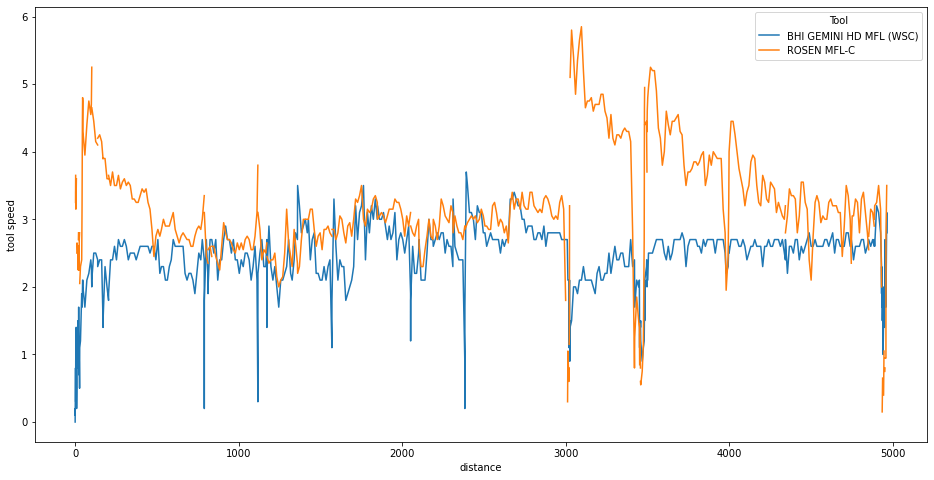

HUN_NIC_762


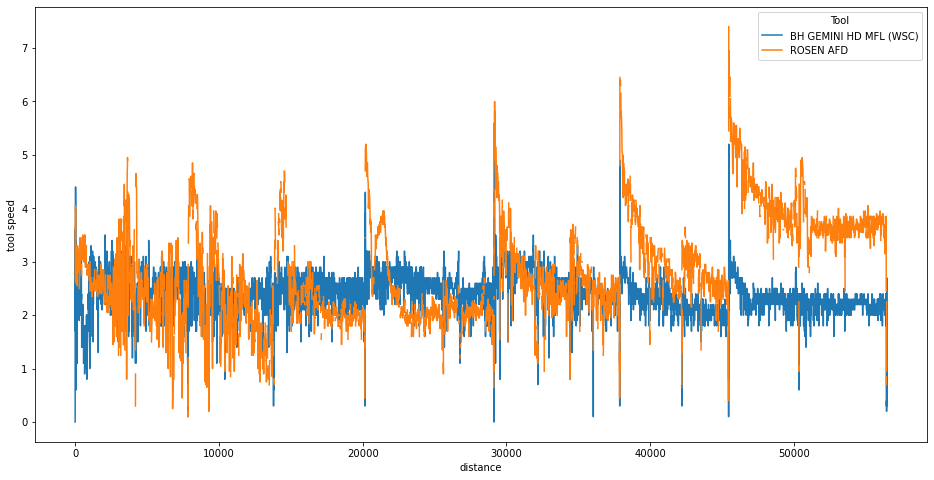

In [6]:
for pipeline in pl_list:
    pl_raw = pipelines[pipeline]["data"]
    pl = pd.melt(pl_raw,
                id_vars="Distance",
                var_name="Tool",
                value_name="Velocity")
    pl["Tool"] = pl["Tool"].astype('category')
    print(pipeline)
    plt.figure(figsize=(16,8))
    ax = sns.lineplot(x="Distance", y="Velocity", hue="Tool", data=pl)
    ax.set(xlabel="distance", ylabel="tool speed")
    plt.show()

### Invert Gemini?
The plots above suggest that the Gemini is _inversely_ correlated with the Rosen MFL-C.  A quick plot of the raw data does not confirm this.  However, we examine examine the _peaks_ of the inverse below.

In [8]:
pl_raw

,Distance,BHI GEMINI HD MFL (WSC),ROSEN MFL-C
0,0.514230,0.0,NaN
1,0.675838,0.2,NaN
2,0.832144,0.1,NaN
3,1.827121,0.5,2.05
4,2.348656,0.7,NaN
...,...,...,...
548,4959.095216,1.8,0.95
549,4959.256063,1.7,2.75
550,4963.955866,3.1,3.50
551,4964.118846,2.8,NaN


NIC_PMA_610


<Figure size 720x720 with 0 Axes>

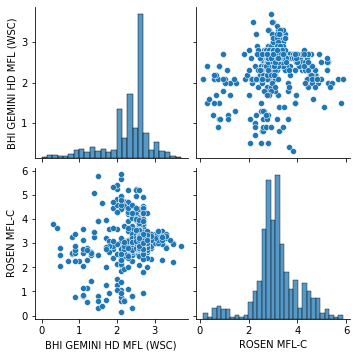

HUN_NIC_762


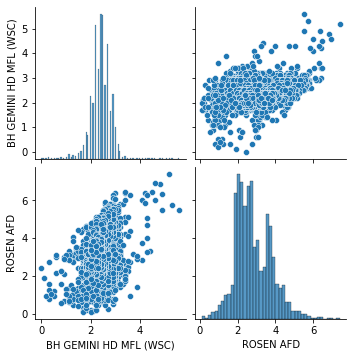

In [9]:
plt.figure(figsize=(10,10))
for pipeline in pl_list:
    pl_raw = pipelines[pipeline]["data"]
    print(pipeline)
    ax = sns.pairplot(pl_raw.iloc[:, 1:4])
    plt.show()

## Intermediate conclusion
There is very little correlation between the peaks for the MFL-C and the BHI Gemini.  It is not clear that the Gemini will be much use when predicting the MFL-C and ultimately the EMAT.

# Match peaks for NIC_PMA_610
The NIC_PMA_610 pipeline has data for the MFL-C and the BH Gemini.  We can start with it.

In [10]:
pipeline = "NIC_PMA_610"
pipelines[pipeline]["tools"].keys()

dict_keys(['BHI GEMINI HD MFL (WSC)', 'ROSEN MFL-C'])

### Mark the MFL-C using the existing benchmark velocity threshold

In [11]:
tool = "ROSEN MFL-C"
peak =  tool_params.loc[tool, "Peak"]
dist_thresh = 25

# unpivot data and create temporary dataframe
pl = pd.melt(pipelines[pipeline]["data"],
                id_vars="Distance",
                var_name="Tool",
                value_name="Velocity")
pl["Tool"] = pl["Tool"].astype('category')

pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
localdec.mark_excursion(tool, peak, dist_thresh, pl)
print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

ROSEN MFL-C peaks 10.0


### Match the BH(I) Gemini with Rosen MFL-C

In [13]:
vals = list()
tool = "BHI GEMINI HD MFL (WSC)"
for i in np.arange(3, 3.5, .05):
    pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
    localdec.mark_excursion(tool, i, dist_thresh, pl)
    vals.append((tool, round(i,3), pl.groupby("Tool").get_group(tool)["Excursion"].sum()))
vals

[('BHI GEMINI HD MFL (WSC)', 3.0, 11.0),
 ('BHI GEMINI HD MFL (WSC)', 3.05, 11.0),
 ('BHI GEMINI HD MFL (WSC)', 3.1, 11.0),
 ('BHI GEMINI HD MFL (WSC)', 3.15, 10.0),
 ('BHI GEMINI HD MFL (WSC)', 3.2, 10.0),
 ('BHI GEMINI HD MFL (WSC)', 3.25, 7.0),
 ('BHI GEMINI HD MFL (WSC)', 3.3, 7.0),
 ('BHI GEMINI HD MFL (WSC)', 3.35, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.4, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.45, 3.0)]

In [14]:
tool = "BHI GEMINI HD MFL (WSC)"
peak =  3.15 # selected based on iterations above
pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
localdec.mark_excursion(tool, peak, dist_thresh, pl)
print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

BHI GEMINI HD MFL (WSC) peaks 10.0


### Plot peaks

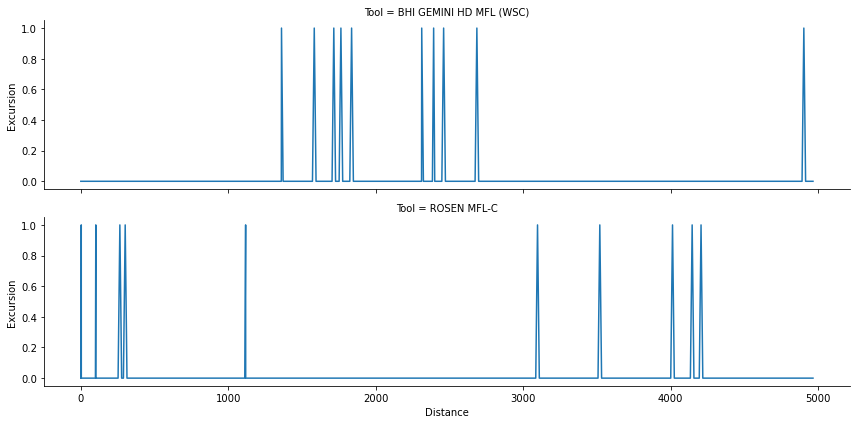

In [15]:
args = ("Distance", "Excursion")
g = sns.FacetGrid(pl, row="Tool", aspect=4)
g.map(sns.lineplot, *args);

### Conclusion
It is not worth mapping peaks for the BH Gemini and Rosen AFL.  The BH Gemini cannot serve as the "Rosetta Stone" to link these tools together.

## Try inverted Gemini profile

In [16]:
pipeline = "NIC_PMA_610"
pl = pd.melt(pipelines[pipeline]["data"],
                id_vars="Distance",
                var_name="Tool",
                value_name="Velocity")
pl["Tool"] = pl["Tool"].astype('category')

### Get the min and max velocity for the Gemini
The transformation is new_velocity = max(velocity) - velocity.  So the previous peak is now zero and zero is the new peak.

In [17]:
pl.groupby("Tool")["Velocity"].max(), pl.groupby("Tool")["Velocity"].min()

(Tool
 BHI GEMINI HD MFL (WSC)    3.70
 ROSEN MFL-C                5.85
 Name: Velocity, dtype: float64,
 Tool
 BHI GEMINI HD MFL (WSC)    0.00
 ROSEN MFL-C                0.15
 Name: Velocity, dtype: float64)

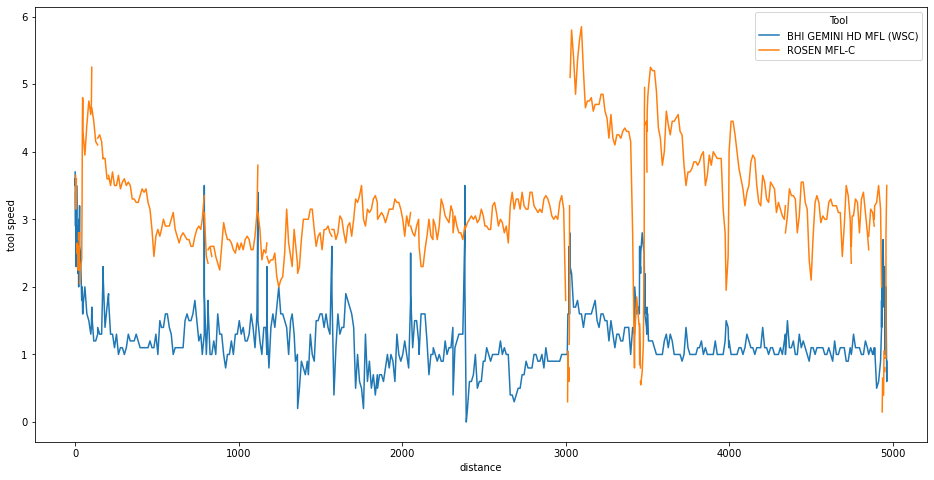

In [18]:
pl.loc[pl["Tool"] == tool, "Velocity"] = 3.7 - pl.loc[pl["Tool"] == tool, "Velocity"]
plt.figure(figsize=(16,8))
ax = sns.lineplot(x="Distance", y="Velocity", hue="Tool", data=pl)
ax.set(xlabel="distance", ylabel="tool speed")
plt.show()

### Redo the iterative search for threshold peak velocity for the inverted data

In [25]:
vals = list()
tool = "BHI GEMINI HD MFL (WSC)"
pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
for i in np.arange(2.2, 4, 0.05):
    pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
    localdec.mark_excursion(tool, i, dist_thresh, pl)
    vals.append((tool, round(i,3), pl.groupby("Tool").get_group(tool)["Excursion"].sum()))
vals

[('BHI GEMINI HD MFL (WSC)', 2.2, 11.0),
 ('BHI GEMINI HD MFL (WSC)', 2.25, 11.0),
 ('BHI GEMINI HD MFL (WSC)', 2.3, 11.0),
 ('BHI GEMINI HD MFL (WSC)', 2.35, 9.0),
 ('BHI GEMINI HD MFL (WSC)', 2.4, 9.0),
 ('BHI GEMINI HD MFL (WSC)', 2.45, 9.0),
 ('BHI GEMINI HD MFL (WSC)', 2.5, 9.0),
 ('BHI GEMINI HD MFL (WSC)', 2.55, 8.0),
 ('BHI GEMINI HD MFL (WSC)', 2.6, 8.0),
 ('BHI GEMINI HD MFL (WSC)', 2.65, 7.0),
 ('BHI GEMINI HD MFL (WSC)', 2.7, 7.0),
 ('BHI GEMINI HD MFL (WSC)', 2.75, 6.0),
 ('BHI GEMINI HD MFL (WSC)', 2.8, 6.0),
 ('BHI GEMINI HD MFL (WSC)', 2.85, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 2.9, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 2.95, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.0, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.05, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.1, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.15, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.2, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.25, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.3, 4.0),
 ('BHI GEMINI HD MFL (WSC)', 3.35, 4.0),
 ('BHI GEMINI HD MFL (WSC

Mark the Gemini with the selected threshold from above

In [26]:
tool = "BHI GEMINI HD MFL (WSC)"
peak =  2.35 # selected based on iterations above
pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
localdec.mark_excursion(tool, peak, dist_thresh, pl)
print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

BHI GEMINI HD MFL (WSC) peaks 9.0


Re-run the MFL-C for this dataset

In [27]:
tool = "ROSEN MFL-C"
peak =  tool_params.loc[tool, "Peak"]
pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
localdec.mark_excursion(tool, peak, dist_thresh, pl)
print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

ROSEN MFL-C peaks 10.0


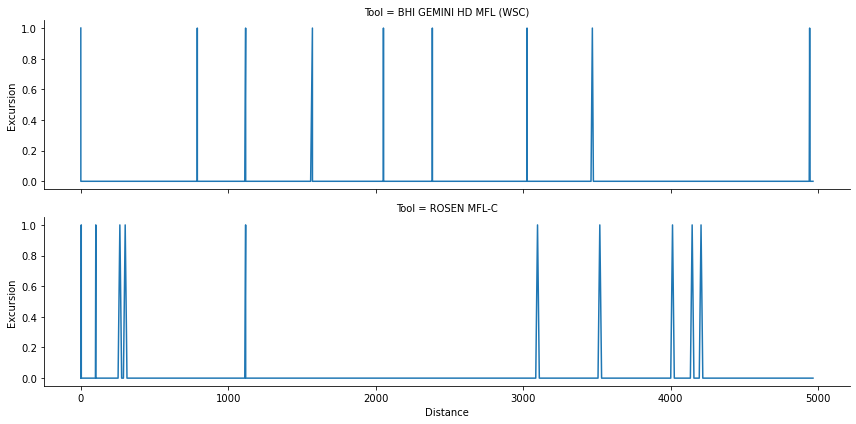

In [28]:
args = ("Distance", "Excursion")
g = sns.FacetGrid(pl, row="Tool", aspect=4)
g.map(sns.lineplot, *args);

# Match peaks for HUN_NIC_762¶

In [29]:
pipeline = "HUN_NIC_762"
pipelines[pipeline]["tools"].keys()

dict_keys(['BH GEMINI HD MFL (WSC)', 'ROSEN AFD'])

In [30]:
tool = "BH GEMINI HD MFL (WSC)"
peak =  tool_params.loc[tool, "Peak"]

# unpivot data and create temporary dataframe
pl = pd.melt(pipelines[pipeline]["data"],
                id_vars="Distance",
                var_name="Tool",
                value_name="Velocity")
pl["Tool"] = pl["Tool"].astype('category')
# invert speed
pl.loc[pl["Tool"] == tool, "Velocity"] = 3.7 - pl.loc[pl["Tool"] == tool, "Velocity"]
pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
localdec.mark_excursion(tool, peak, dist_thresh, pl)
print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

BH GEMINI HD MFL (WSC) peaks 6.0


In [36]:
vals = list()
tool = "ROSEN AFD"
for i in np.arange(.5, .8, .01):
    pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
    localdec.mark_excursion(tool, i, dist_thresh, pl)
    vals.append((tool, round(i,3), pl.groupby("Tool").get_group(tool)["Excursion"].sum()))
vals

[('ROSEN AFD', 0.5, 1.0),
 ('ROSEN AFD', 0.51, 2.0),
 ('ROSEN AFD', 0.52, 2.0),
 ('ROSEN AFD', 0.53, 2.0),
 ('ROSEN AFD', 0.54, 2.0),
 ('ROSEN AFD', 0.55, 2.0),
 ('ROSEN AFD', 0.56, 2.0),
 ('ROSEN AFD', 0.57, 2.0),
 ('ROSEN AFD', 0.58, 2.0),
 ('ROSEN AFD', 0.59, 2.0),
 ('ROSEN AFD', 0.6, 2.0),
 ('ROSEN AFD', 0.61, 2.0),
 ('ROSEN AFD', 0.62, 2.0),
 ('ROSEN AFD', 0.63, 2.0),
 ('ROSEN AFD', 0.64, 2.0),
 ('ROSEN AFD', 0.65, 3.0),
 ('ROSEN AFD', 0.66, 3.0),
 ('ROSEN AFD', 0.67, 3.0),
 ('ROSEN AFD', 0.68, 3.0),
 ('ROSEN AFD', 0.69, 3.0),
 ('ROSEN AFD', 0.7, 5.0),
 ('ROSEN AFD', 0.71, 5.0),
 ('ROSEN AFD', 0.72, 5.0),
 ('ROSEN AFD', 0.73, 5.0),
 ('ROSEN AFD', 0.74, 5.0),
 ('ROSEN AFD', 0.75, 5.0),
 ('ROSEN AFD', 0.76, 5.0),
 ('ROSEN AFD', 0.77, 5.0),
 ('ROSEN AFD', 0.78, 5.0),
 ('ROSEN AFD', 0.79, 5.0),
 ('ROSEN AFD', 0.8, 8.0)]

In [37]:
tool = "ROSEN AFD"
peak =  0.79 # selected based on iterations above
pl.loc[pl["Tool"] == tool, "Excursion"] = 0 # reset
localdec.mark_excursion(tool, peak, dist_thresh, pl)
print("{} peaks {}".format(tool, pl.groupby("Tool").get_group(tool)["Excursion"].sum()))

ROSEN AFD peaks 5.0


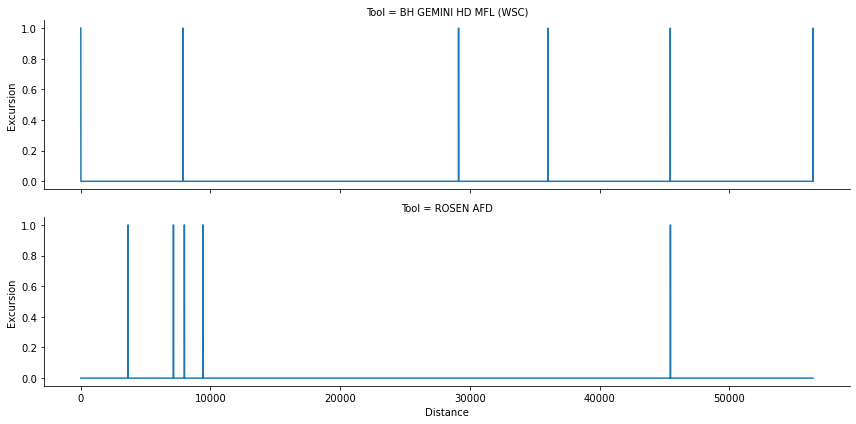

In [38]:
args = ("Distance", "Excursion")
g = sns.FacetGrid(pl, row="Tool", aspect=4)
g.map(sns.lineplot, *args);

# Conclusion
A chained estimate might not work (AFD predicts Gemini predicts MFL-C predicts EMAT).  Perhaps it is better simply to use the AFD excursions to estimate the location of EMAT excursions and to set the frequency per unit length to the observed frequency for the EMAT in LIV_PAT_457.